In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

In [3]:
df = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

dt = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
df.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


In [5]:
dt.head()

,text,label
0,VinTee [USERNAME] [USERNAME] and [USERNAME] Ka...,1
1,binay's sidekicks were employees of makati cit...,1
2,This is expected as we use different methodol...,0
3,Ang tanga tanga talaga ni Nancy Binay eh. Tskkk.,1
4,Binay giving away bracelets after every selfie...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


In [7]:
df.isnull().sum()

,0
text,0
label,0


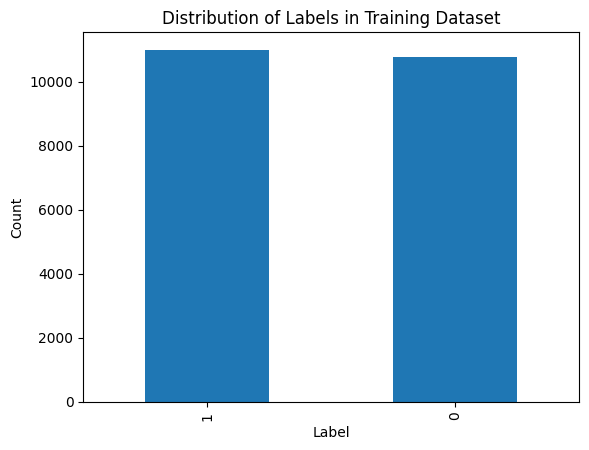

In [8]:
# prompt: create a chart for the label in df_train

import matplotlib.pyplot as plt

# Assuming 'label' is the column containing the labels
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels in Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [9]:
# Initialize an empty set
stopwords_set = set()

# Open the text file in read mode
with open('stopwords-tl.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Strip leading/trailing whitespace (including newline characters)
        word = line.strip()
        # Add the word to the set
        stopwords_set.add(word)

# Print the resulting set
print(stopwords_set)

{'apat', 'ilan', 'naging', 'myself', 'which', 'may', 'marapat', 'who', 'ibaba', 'kanino', 'kumuha', 'your', 'too', 'and', 'likod', 'iyon', 'nakita', 'we', 'be', 'both', 'habang', 'a', 'because', 'his', 'ngayon', 'ko', 'sabi', 'pa', 'palabas', 'pababa', 'the', 'kong', 'dahil', 'kaysa', 'have', 'before', 'some', 'laban', 'below', 'just', 'walang', 'can', 'ikaw', 'aming', 'between', 'kami', 'marami', 'is', 'dapat', 'after', 'ginawang', 'kulang', 'those', 'down', 'where', 'against', 'same', 'tayo', 'don', 'been', 'nila', 'sino', 'paraan', 'other', 'on', 'napaka', 'kailangan', 'iyong', 'them', 'what', 'gagawin', 'pero', 'so', 'into', 'does', 'mga', 'siya', 'nagkaroon', 'lahat', 'that', 'inyong', 'nito', 'are', 'pagkatapos', 'sarili', 'minsan', 'an', 'yourselves', 'more', 'ng', 'during', 'doon', 'to', 'para', 'ilalim', 'amin', 'nabanggit', 'pamamagitan', 'or', 'kanila', 'any', 'ay', 'yourself', 'do', 'ka', 'hanggang', 'kanilang', 'he', 'now', 'as', 'pataas', 'mahusay', 'isang', 'na', 'kanya'

In [10]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download("stopwords")
# nltk.download('punkt')

def clean_message(message):
    message = re.sub("[^A-Za-z]", " ", message) #1
    message = message.lower() #2
    message = message.split() #3
    stemmer = PorterStemmer()   #4. to find the  root meaning word of each word
    message = [stemmer.stem(word) for word in message if word not in stopwords_set] #5
    message = " ".join(message) #6 #Keeping cleaned words together
    return message

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


In [12]:
messages = []
for i in range(0, len(df)):
    message = clean_message(df.text[i])
    messages.append(message)
df = df.drop(["text"],axis=1)
df['messages'] = messages
df.head()

,label,messages
0,1,presidenti candid mar roxa impli govt liabl re...
1,1,parang mali sumunod patalasta nescaf coffe bla...
2,1,bet pula kulay posa
3,0,usernam kakampink
4,1,parang tahimik pink doc willi ong reaction paper


In [13]:
messages = []
for i in range(0, len(dt)):
    message = clean_message(dt.text[i])
    messages.append(message)
dt = dt.drop(["text"],axis=1)
dt['messages'] = messages
dt.head()

,label,messages
0,1,vinte usernam usernam usernam di aasenso pina ...
1,1,binay sidekick employe makati citi hall abl de...
2,0,expect use differ methodolog puls asia survey ...
3,1,tanga tanga talaga nanci binay eh tskkk
4,0,binay give away bracelet everi selfi usernam


In [14]:
x = df["messages"].values
y = df["label"].values
x_test = dt["messages"].values
y_test = dt["label"].values


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vect1 = CountVectorizer(stop_words='english',max_df=0.5)

#fitting train data and then transforming it to count matrix#fitting
X_train_transformed = vect1.fit_transform(x)
X_test_transformed = vect1.transform(x_test)


In [16]:
# importing naive bayes algorithm
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

#fitting the model into train data
nb.fit(X_train_transformed, y)

#predicting the model on train and test data
y_pred_test = nb.predict(X_test_transformed)


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(accuracy_score(y_test,y_pred_test)*100)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision
precision = precision_score(y_test, y_pred_test)
print(f"Precision: {precision:.2f}")

# Calculate sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_test)
print(f"Sensitivity (Recall): {sensitivity:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_test)
print(f"F1 Score: {f1:.2f}")

#Making Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_test)
print(cm)

83.64285714285714
Accuracy: 83.64%
Precision: 0.81
Sensitivity (Recall): 0.89


NameError: name 'f1_score' is not defined

In [31]:
new_text = pd.Series('hello world i love u')
new_text_transform = vect1.transform(new_text)
print(" The message is a" ,nb.predict(new_text_transform))

 The message is a [0]
